# PHYSICS 3G03 HW 1: Optimization, coordinate descent {-}
## Matthew Bain (001406931) {-}

We start by importing all the Python libraries we will need for this project.

In [1]:
# import dependencies
import numpy as np               # numpy for vectorization functionality etc.
import numpy.linalg as LA        # linalg module of numpy for efficient vector/matrix computations
import matplotlib.pyplot as plt  # pyplot module of matplotlib for plotting

## **Exercise 1** *Random search and the Rosenbrock Banana function* {-}

**1.1** In this exercise we implement the `random_search` function that was started for us.

The random search algorithm is one approach to minimizing a cost function, `g`. A cost function usually represents the performance of a model we've built to understand or make predictions about a dataset. The parameter `w` is a vector of values (representing a point in the input space of `g`) with respect to which we minimize `g`. Random search randomly generates `num_samples` different directions from a point `w`, and travels in the direction that reduces the value of `g` the most, with a step length of `alpha`.

*Exercise notes: treat `w` as the starting point. Store all candidate directions in `directions` and corresponding weights in `w_candidates`. Evaluate the cost function at all `w_candidates`.*

### Implementing random search {-}

What we're given:

In [2]:
# random search function -- starting point
def random_search(g, alpha_choice, max_its, w, num_samples):
    # run random search
    w_history = []      # container for w history
    cost_history = []   # container for corresponding cost function history
    alpha = 0
    for k in range(1, max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice

    return w_history,cost_history

We expand the above according to the following notes:
- Starting from `w`, we generate `num_samples` potential directions and store them in `directions`
  - Each direction is an $n$-dimensional vector, where $n$ corresponds to the length of `w` (i.e., the dimension of the input space).
  - We randomly sample each component of each vector from the standard normal distribution, $N(0,1)$, -- i.e., a distribution centered at 0, with ~2/3 of values falling between -1 and 1. 
  - Randomly sampling component values from the normal distribution, as opposed to from the uniform distribution on the interval $[-1, 1]$, is, somewhat counterintuitively, the approach that is least biased (i.e., yields the 'most random' directions). 
  - We could also sample angles $\theta$ between $[0, 2\pi]$ and treat our (unit) vector as the corresponding direction $[\cos(\theta), \sin(\theta)]$. This is perfectly natural in two dimensions but doesn't generalize as well to higher dimensions. More on methods for choosing a unit vector in this article: [The Best Way to Pick a Unit Vector - Don Cross, Toward Data Science](https://towardsdatascience.com/the-best-way-to-pick-a-unit-vector-7bd0cc54f9b).

<break>

- Next we normalize each direction vector, and, scaling by `alpha`, add them to `w` (i.e., 'take a step' in each direction), storing the results in `w_candidates`.
- We then evaluate `g` at each candidate `w` and select the one that yields the lowest value (i.e., the greatest cost decrease).
- This gives us our new value of `w`, which we store in `w_history`. We store the corresponding cost in `cost_history`.
- We iterate this process `max_its` times, or until our randomly generated directions fail to yield a candidate `w` that decreases `g`.

The implementation:

In [3]:
# seed the random number generator
np.random.seed(19680801)

# random search (we add an optional keyword argument 'vec' which takes on value 1 or 0 based on whether input w is meant to be treated as a position vector or an array of coordinate values (as in 1.4,1.5, where cost function treats each coordinate separately))
def random_search(g, alpha_choice, max_its, w, num_samples, **kwargs):
    
    # assign optional 'vec' parameter to variable (default to 1) (personal note: this approach was not necessary -- see function in 1.4,1.5)
    vec = kwargs.get('vec', 1)
    

    # run random search
    w_history = []      # container for w history
    cost_history = []   # container for corresponding cost function history
    prop_descent = []   # container for tracking proportion of directions 

    # store initial values of 'w' and 'g'
    w_history.append(list(w))

    if vec == 1:
        cost_history.append(g(w))
    elif vec == 0:
        cost_history.append(g(w[0], w[1]))
    
    alpha = 0
    for it in range(1, max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(it) # in diminishing case we make step length inversely proportional to iteration
        else:
            alpha = alpha_choice # in the case that alpha is a constant
        
        ## -- generate random directions --
        # generate random directions (represent as array of 'num_samples' vectors of length determined by w)
        directions = np.random.randn(len(w), num_samples)

        # compute vector lengths column-wise (returns 1 x 'num_samples' array)
        directions_len = LA.norm(directions, axis = 0) 

        # normalize directions by vector-wise division by elements in 'directions_len'
        directions = directions/directions_len 
    
        ## -- find direction that minimizes cost function --
        # starting from 'w', "take a step" in each 'candidate direction'
        w_candidates = ((directions.T)*alpha + w).T # transpose 'directions' to add each to w

        # use 'map' to convert candidate points to list of vectors to easily evaluate g over all candidates
        w_candidates = map(list, w_candidates.T) 
        w_candidates = list(w_candidates)

        ## -- evaluate cost function at each candidate point (most compact/efficient method I can think of...) --
        if vec == 1:
            g_candidates = np.array([g(np.array(wi)) for wi in w_candidates]) 
        elif vec == 0:
            g_candidates = np.array([g(wi[0], wi[1]) for wi in w_candidates]) 

        min_ix = np.argmin(g_candidates) # identify index of argument (direction) that minimizes cost 
        g_min = g_candidates[min_ix]

        ## -- store new values --
        # if iteration 1 or new w reduces g, overwrite 'w' and store g; else stay in place
        if (it == 1) or ( g_min < cost_history[-1] ):
            w = w_candidates[min_ix]
            w_history.append(w)
            cost_history.append(g_min)
        else:
            # store old 'w' and 'g' again
            w_history.append(w)
            cost_history.append(cost_history[-1])

    return w_history, cost_history

In [4]:
g = lambda w: np.dot(w.T,w) + 2
g = lambda w1, w2: 100 * np.sum(np.square(w2 - np.dot(w1.T, w1))) + np.sum(np.square(w1 - 1))
alpha_choice = 1; w = np.array([3,4]); num_samples = 1000; max_its = 5; vec = 0

directions = np.random.randn(len(w), num_samples)
directions_len = LA.norm(directions, axis = 0) 
directions = directions/directions_len 
w_candidates = ((directions.T)*alpha_choice + w).T

w_candidates = map(list, w_candidates.T) 
w_candidates = list(w_candidates)

## evaluate cost function at each candidate point
if vec == 1:
    g_candidates = np.array([g(np.array(wi)) for wi in w_candidates]) 
elif vec == 0:
    g_candidates = np.array([g(wi[0], wi[1]) for wi in w_candidates]) 

min_ix = np.argmin(g_candidates) # identify index of argument (direction) that minimizes cost 
g_min = g_candidates[min_ix]


**1.2** In this exercise we put our implementation of `random_search` to the test with an example. 

### Testing `random_search` {-}

In [5]:
# our example cost function (defined concisely in python using a lambda function) 
g = lambda w: np.dot(w.T,w) + 2
alpha_choice = 1; w = np.array([3,4]); num_samples = 1000; max_its = 5 # choices of parameters

# run algorithm
w_history, cost_history = random_search(g, alpha_choice, max_its, w, num_samples)

Below we plot `w_history` (each point in 3-space)

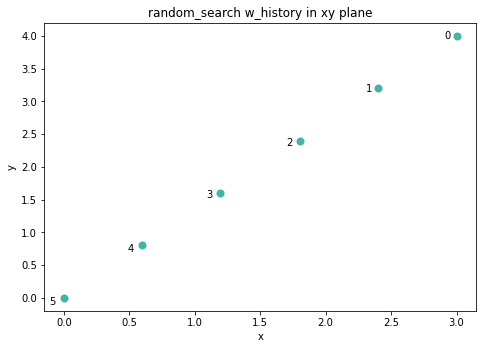

In [6]:
## -- define general plotting parameters --
plt_clrs = (np.array([94,255,231])/360, np.array([133,94,214])/360, np.array([110,250,152])/360)

## -- plot 'w_history' --
# setup data (using Python list comprehension)
x = [item[0] for item in w_history] # store all 'x' coordinates of points
y = [item[1] for item in w_history] # store all 'y' coordinates of points

# setup plot
fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])

# plot scatter in the xy plane
ax.scatter(x, y, color = plt_clrs[0], linewidth = 2)

# label points
for w in range(0, len(w_history), 1):
    ax.annotate(str(w), xy = (x[w], y[w]), xytext = (x[w]-15, y[w]-7), textcoords = 'offset points')

# axis/figure labels
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('random_search w_history in xy plane')

# output figure
plt.show()


Each point is labelled with the iteration of `random_search` to which it corresponds. Initial value is labelled as '0'. 

Notice that the cost function has a global minimum at $\omega = (0,0)$, which `w` appears to be steadily approaching with each iteration of `random_search`.

Below we plot `cost_history` as a function of random search iteration. 

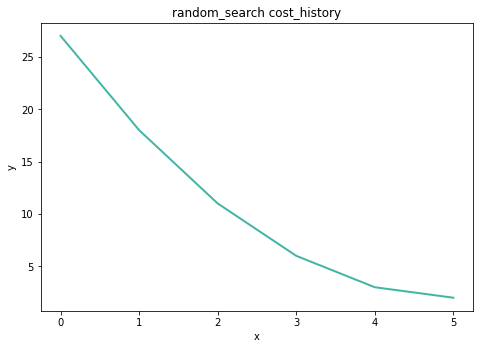

In [7]:
## -- plot 'w_history' --
# setup data (using Python list comprehension)
x = range(0, len(w_history), 1)
y = cost_history # store all 'y' coordinates of points

# setup plot
fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])

# plot scatter in the xy plane
ax.plot(x, y, color = plt_clrs[0], linewidth = 2)

# axis/figure labels
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('random_search cost_history')

# output figure
plt.show()

Notice that the global minimum of the cost function $g(0,0)$ occurs at a value of 2, to which `cost_history` appears be converging.

Based on these findings we can conclude that `random_search` performs reasonably well under these fairly uncomplicated circumstances.

**1.3** Now we explore how step length affects the effectiveness of the random search algorithm.

### Experimenting with step length {-}

Below we repeat the analysis above for a step length of `alpha` = 0.3.

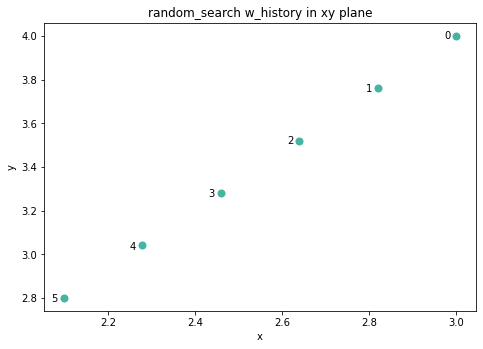

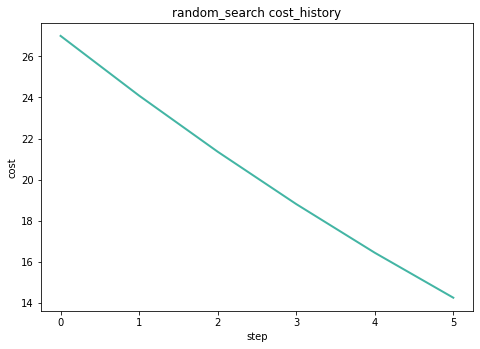

In [8]:
g = lambda w: np.dot(w.T,w) + 2
alpha_choice = .3; w = np.array([3,4]); num_samples = 1000; max_its = 5
w_history, cost_history = random_search(g, alpha_choice, max_its, w, num_samples)

## -- plot 'w_history' --
x = [item[0] for item in w_history] # store all 'x' coordinates of points
y = [item[1] for item in w_history] # store all 'y' coordinates of points

fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])

ax.scatter(x, y, color = plt_clrs[0], linewidth = 2)

for w in range(0, len(w_history), 1):
    ax.annotate(str(w), xy = (x[w], y[w]), xytext = (x[w]-15, y[w]-7), textcoords = 'offset points')

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('random_search w_history in xy plane')

plt.show()

## -- plot 'cost_history' --
x = range(0, len(w_history), 1)
y = cost_history

fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(x, y, color = plt_clrs[0], linewidth = 2)

ax.set_xlabel('step')
ax.set_ylabel('cost')
plt.title('random_search cost_history')

plt.show()

Notice that using a step length of .3 as opposed to 1, as before, `random_search` appears to be approaching the global minimum. However, whereas with a larger step length the algorithm managed to successfully approximate the minimum in 5 iterations, in the above case `w` fails to converge to the minimum within the same 5 iterations.

**1.4** Now we experiment with higher-dimensional cost functions and different step length rules.

Below we define The Rosenbrock Banana function and run `random_search` with two sets of parameters, the first with a constant and the second a diminishing step length.

In [9]:
# define cost function
# g = lambda w1, w2: 100 * ((w2 - w1**2))**2 + (w1 - 1)**2
g = lambda w: 100 * ((w[1] - w[0]**2)**2) + (w[0] - 1)**2 # using this approach we can circumvent 'vector vs coordinates' problem altogether...

# set random search parameters
w = [-2, -2]; num_samples = 1000; max_its = 50

# case 1: constant step length
alpha_choice = 1
w_history_case1, cost_history_case1 = random_search(g, alpha_choice, max_its, w, num_samples)

# case 2: decreasing step length
alpha_choice = 'diminishing'
w_history_case2, cost_history_case2 = random_search(g, alpha_choice, max_its, w, num_samples)

Below we plot the corresponding cost history for each case.

/var/folders/1l/bzgw9j4d1pl2c6j9ngntg5mh0000gn/T/ipykernel_21865/622109294.py:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([line_case1, line_case2], labels = ['constant', 'diminishing'], frameon = 0)


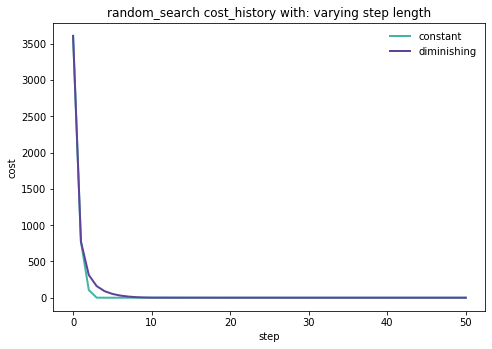

In [10]:
## -- plot 'cost_history' --
# store data
x_case1 = range(0, len(w_history_case1), 1)
x_case2 = range(0, len(w_history_case2), 1)
y_case1 = cost_history_case1
y_case2 = cost_history_case2

# setup plot
fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])

# plot
line_case1 = ax.plot(x_case1, y_case1, color = plt_clrs[0], linewidth = 2)
line_case2 = ax.plot(x_case2, y_case2, color = plt_clrs[1], linewidth = 2)

# add labels
ax.set_xlabel('step')
ax.set_ylabel('cost')
plt.title('random_search cost_history with: varying step length')

# plot legend
ax.plot(box = 0)
ax.legend([line_case1, line_case2], labels = ['constant', 'diminishing'], frameon = 0)

plt.show()

Now we visualize the trajectory of `w_history` over a contour plot of the cost function -- providing a 2-dimensional representation of how the 'position vector' moved around the cost function in its search for a minimum. The `static_plotter` function is from the *Machine Learning Refined* repository [(Watt, 2020)](https://github.com/jermwatt/machine_learning_refined).

case 1: constant step length


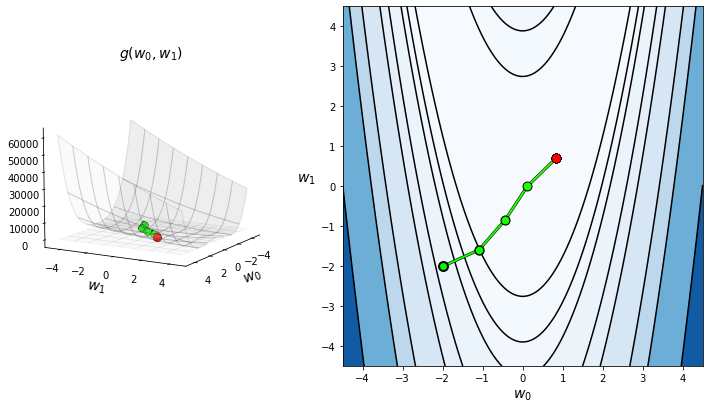

case 2: diminishing step length


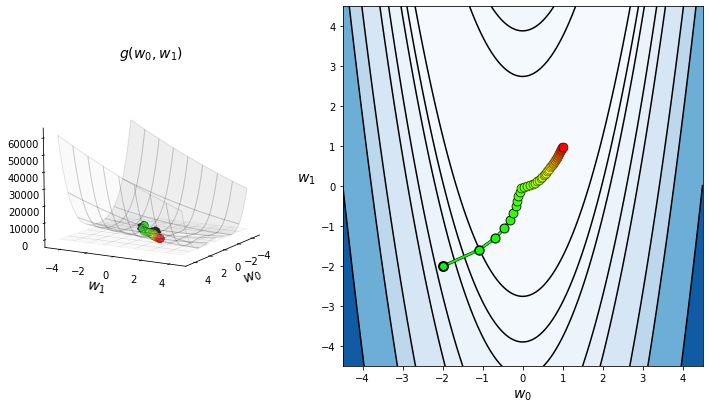

In [11]:
# from mlrefined_libraries >  math_optimization_library import 'static_plotter' function
from borrowed_code import static_plotter
static_plotter = static_plotter.Visualizer()

# convert 'w_history' from list to array for plotting convenience
w_history_case1 = np.array(w_history_case1)
w_history_case2 = np.array(w_history_case2)

# to prevent warning messages from appearing in the report
import warnings;
warnings.filterwarnings('ignore')

# to prevent long plot-related warnings that I can't unpack from outputting iteratively
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# plot (MLR 3D function + contour plot visualization for random search optimization)
print('case 1: constant step length')
plot_case1 = static_plotter.two_input_surface_contour_plot(g, w_history_case1, view = [10, 30], xmin = -4.5, xmax = 4.5, ymin = -4.5, ymax = 4.5)
print('case 2: diminishing step length')
plot_case2 = static_plotter.two_input_surface_contour_plot(g, w_history_case2, view = [10, 30], xmin = -4.5, xmax = 4.5, ymin = -4.5, ymax = 4.5)

On the left hand side of the above plots we see a surface plot of the cost function, with the input variables `w1` and `w2` (here `w0` and `w1`) on the xy axes. On the right hand side is a contour plot of the same cost function, visualized over the same domain. The overlaid points (green -> red) show the trajectory of the input variables as they are titrated by `random_search` in search of the minimum (occuring at (1,1)). Colours are based on random search step, beginning green and terminating red.

From these plots we can see that case 2 (diminishing step length) performs better than case 1 (constant length) for this function. Both come close to the true minimum but in the same number of iterations case 2 comes closer. In the top contour plot case 1's major shortcoming is made clear. Over the first five iterations of random search, `w` is adjusted in the direction of the minimum, but on the 5th iteration it appears to get stuck, failing to take another step in the 45 remaining iterations. This indicates that on the 5th step the algorithm searches in too wide a radius for a point that further reduces cost, and as a result misses all the points nearer to the minimum. A diminishing step length seems to fix this problem. From the bottom contour plot we can see that random search appears to successfully identify input values that bring the cost function increasingly close to its minimum over all 50 iterations.

**1.5** Now we experiment with a cost function with multiple minima.

### Multiple minima {-}
Below we define the function, choose some starting parameters, and run random search.

parameters: alpha = 0.1 ; max iterations = 500 ; w = [-1, 0.5] ; # samples = 2000


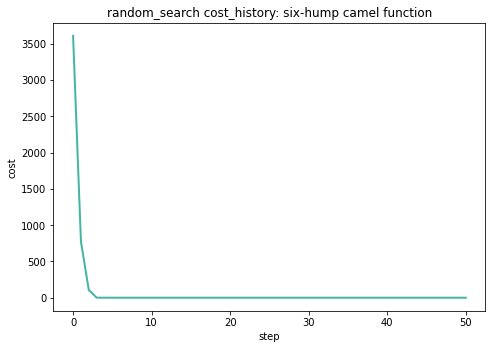

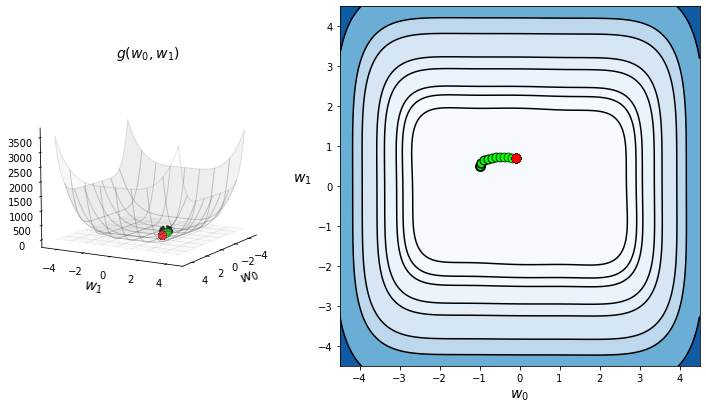

w = [-0.09020526  0.71280665]
g(w) = -1.031627808765009 

parameters: alpha = 0.1 ; max iterations = 500 ; w = [-1, 0.1] ; # samples = 1000
w = [-0.042086020752881786, 0.7084688536051066]
g(w) = -1.0227234181790565 

parameters: alpha = diminishing ; max iterations = 20 ; w = [-1.9, 0.1] ; # samples = 1000
w = [-1.6872636654236077, 0.7938970540494146]
g(w) = -0.21297658377131523


In [42]:
# define cost function
g = lambda w: (4 - 2.1*(w[0]**2) + (1/3)*(w[0]**4))*(w[0]**2) + w[0]*w[1] + (-4 + 4*(w[1]**2))*(w[1]**2)

# set random search parameters and run
alpha_choice = .1; w = [-1, .5]; num_samples = 2000; max_its = 500
print('parameters: alpha =', alpha_choice, '; max iterations =', max_its, '; w =', w, '; # samples =', num_samples) # output starting parameters
w_history, cost_history = random_search(g, alpha_choice, max_its, w, num_samples)

# plot cost history
x = range(0, len(w_history), 1)
y = cost_history

fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(x_case1, y_case1, color = plt_clrs[0], linewidth = 2)

ax.set_xlabel('step')
ax.set_ylabel('cost')
plt.title('random_search cost_history: six-hump camel function')

# contour plot
w_history = np.array(w_history)
static_plotter.two_input_surface_contour_plot(g, w_history, view = [10, 30], xmin = -4.5, xmax = 4.5, ymin = -4.5, ymax = 4.5)

# output final point reached by random search
print('w =', w_history[-1])
print('g(w) =', cost_history[-1], '\n')

# try out some other parameters
alpha_choice = .1; w = [-1, .1]; num_samples = 1000; max_its = 500
print('parameters: alpha =', alpha_choice, '; max iterations =', max_its, '; w =', w, '; # samples =', num_samples)
w_history, cost_history = random_search(g, alpha_choice, max_its, w, num_samples)
print('w =', w_history[-1])
print('g(w) =', cost_history[-1], '\n')

alpha_choice = 'diminishing'; w = [-1.9, .1]; num_samples = 1000; max_its = 20
print('parameters: alpha =', alpha_choice, '; max iterations =', max_its, '; w =', w, '; # samples =', num_samples)
w_history, cost_history = random_search(g, alpha_choice, max_its, w, num_samples)
print('w =', w_history[-1])
print('g(w) =', cost_history[-1])


We know based on the information we are given that in the domain $\omega1 \in [−3,3]$, $\omega2 \in [−2,2]$ it has 2 minima, at (0.0898,−0.7126) and (−0.0898, 0.7126). Comparing these values with the final point and cost reached by random search, we see that random search is highly dependent on its input parameters. We have the most success with the parameters: alpha_choice = .1; num_samples = 2000; max_its = 500 and a starting point of [-1, .5]. In this case (which is plotted in the surface and contour plots above), random search converges on the point (−0.0898, 0.7126). We have different degrees of success with different parameters, but in general it would seem that random search performs best with many iterations and samples, albeit at the cost of efficiency, and is more variable with respect to step length and starting point.

## **Exercise 2** *Curse of dimensionality* {-}

### The curse of dimensionality {-}

In this exercise we explore the curse of dimensionality. We start by revisiting the function in **1.2**. We define a starting point $w_0 = (1,0,...,0)$ with length $N$ equal to the dimension of the space. We use the parameters chosen in **1.2** and consider, for a range of $N$, the proportion of randomly generated directions $P$ that are descent directions. 

In [68]:
# cost function and parameters
g = lambda w: np.dot(w.T,w) + 2
alpha_choice = 1; w = np.array([3,4]); num_samples = 1000; max_its = 5

# for range of 'N', set 'w', run random search, and return proportion of directions that are descent
for N in range(1,25+1,1):
    w = np.zeros((1,25)); w[0,0] = 1
    



In [67]:
w[0,0] = 1
w

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Below we plot proportion of randomly generated directions $% of P$ that are descent directions as a function of $N$.

In [14]:
# plot

What we observe:

## **Exercise 3** *Coordinate search and coordinate descent* {-}

Now we turn our attention from random search to two new algorithms.

### Coordinate search and coordinate descent {-}

**3.1** In this exercise we implement the coordinate search and coordinate descent algorithms.

In [15]:
# code

**3.2** In this exercise we [...]

In [16]:
# code

Now we compare the performance of coordinate search and coordinate descent by plotting the cost history functions.

In [17]:
# plot

What we observe:

## **Exercise 4** *Gradient descent* {-}
In this exercise we implement the `gradient_descent` function that was started for us.

### Gradient descent {-}

We will need to import a couple more packages to complete this exercise.

In [18]:
import autograd.numpy as npa    # autograd wrapped numpy, with alias 'npa'
from autograd import grad       # import module 'grad', which will automatically differentiate and compute the gradient of 'g' at each 'w'

grad

<function autograd.wrap_util.unary_to_nary.<locals>.nary_operator(fun, argnum=0, *nary_op_args, **nary_op_kwargs)>

Our starting point:

In [19]:
# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w]           # container for weight history
    cost_history = [g(w)]          # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return cost_history

We modify the above to get:

In [20]:

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w]           # container for weight history
    cost_history = [g(w)]          # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return cost_history

Thoughts: 